## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

### Data

In [108]:
# path = untar_data(URLs.MNIST_SAMPLE)
path = untar_data(URLs.MNIST)

In [109]:
path

Path('/home/ext-share/.fastai/data/mnist_png')

In [110]:
# !ls /home/ext-share/.fastai/data/mnist_sample

In [111]:
# !ls /home/ext-share/.fastai/data/mnist_png/

In [112]:
# !cp -r /home/ext-share/.fastai/data/mnist_png/train /home/ext-share/.fastai/data/mnist_png/train


In [113]:
im3 = Image.open(path/'train'/'3'/'12.png')
# im3 = Image.open(path/'training'/'3'/'12.png')
show_image(im3);

FileNotFoundError: [Errno 2] No such file or directory: '/home/ext-share/.fastai/data/mnist_png/train/3/12.png'

In [114]:
im3_t = tensor(im3)

df = pd.DataFrame(im3_t[:28,:28])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0,0,0,0,0,0,0,0,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0,0,0,0,0,0,0,0,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0,0,0,0,0,0,0,0,0


In [117]:
# GrandparentSplitter??

In [120]:
# datablock

# GrandparentSplitter require something...  

mnist = DataBlock((ImageBlock(cls=PILImageBW),
                   CategoryBlock), 
                   get_items=get_image_files, 
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
#                    splitter=GrandparentSplitter(),
                   get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [124]:
len(dls.train), len(dls.valid)

(1000, 250)

In [122]:
# il.items[0]

In [128]:
# 28*28 784
# (784) > (1, 28, 28)

784

In [126]:
# 以前やった時は(64, 784) だった

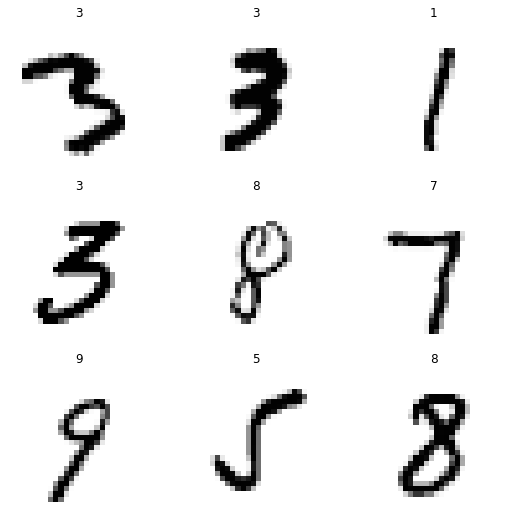

In [129]:
dls.show_batch()

### Basic CNN with batchnorm

In [145]:
# convolutionはnn.Conv2d使うだけ

# stride 2
def conv_stride2(ni,nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [146]:
model = nn.Sequential(
    
    conv_stride2(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    
    conv_stride2(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv_stride2(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    conv_stride2(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv_stride2(16, 10), # 1
    nn.BatchNorm2d(10),
    
    Flatten()     # remove (1,1) grid
)

In [147]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(full=False)
)

In [148]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [149]:
model.cuda()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(full=False)
)

In [150]:
xb = xb.cuda()

In [151]:
model(xb).shape

torch.Size([64, 10])

SuggestedLRs(lr_min=0.4466835975646973, lr_steep=0.007244359701871872)

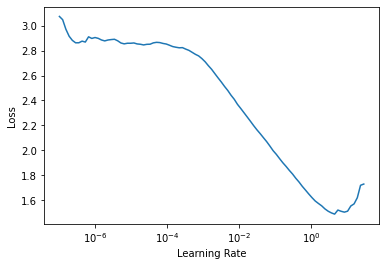

In [152]:
learn.lr_find(end_lr=100)

In [153]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.259998,0.201248,0.973688,00:09
1,0.116302,0.086133,0.982562,00:10
2,0.081666,0.068665,0.986625,00:10


### Refactor

In [172]:
# def conv_stride2(ni,nf):

def conv_stride2_and_bn_relu(ni,nf):
    return nn.Sequential(
        conv_stride2(ni, nf),
        nn.BatchNorm2d(nf),
        nn.ReLU(),
    )

In [173]:
model = nn.Sequential(
    
    conv_stride2_and_bn_relu(1, 8),
    
    conv_stride2_and_bn_relu(8, 16),
    
    conv_stride2_and_bn_relu(16, 32),
    
    conv_stride2_and_bn_relu(32, 16),
    
    conv_stride2(16, 10), # 1
    nn.BatchNorm2d(10),
    
    Flatten()     # remove (1,1) grid
)

In [174]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Flatten(full=

In [175]:
# stride 1
def conv_stride1(ni,nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)

In [176]:
def conv_stride1_and_bn_relu(ni,nf):
    return nn.Sequential(
        conv_stride1(ni, nf),
        nn.BatchNorm2d(nf),
        nn.ReLU(),
    )

In [177]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [178]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 8 x 14 x 14     80         True      
________________________________________________________________
BatchNorm2d          64 x 8 x 14 x 14     16         True      
________________________________________________________________
ReLU                 64 x 8 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 16 x 7 x 7      1,168      True      
________________________________________________________________
BatchNorm2d          64 x 16 x 7 x 7      32         True      
________________________________________________________________
ReLU                 64 x 16 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 32 x 4 x 4      4,640      True      
___________________________________________________

In [179]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.245593,0.210932,0.970125,00:10
1,0.116097,0.088602,0.982437,00:10
2,0.093542,0.073595,0.985000,00:10


In [181]:
# stride 1を使えば延々と長くできる

model = nn.Sequential(
    
    conv_stride2_and_bn_relu(1, 8),
    
    conv_stride1_and_bn_relu(8, 8),
    
    conv_stride2_and_bn_relu(8, 16),
    
    conv_stride1_and_bn_relu(16, 16),
    
    conv_stride2_and_bn_relu(16, 32),
    
    conv_stride1_and_bn_relu(32, 32),
    
    conv_stride2_and_bn_relu(32, 16),
    
    conv_stride1_and_bn_relu(16, 16),
    
    conv_stride2(16, 10), # 1
    nn.BatchNorm2d(10),
    
    Flatten()     # remove (1,1) grid
)

In [182]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [183]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 8 x 14 x 14     80         True      
________________________________________________________________
BatchNorm2d          64 x 8 x 14 x 14     16         True      
________________________________________________________________
ReLU                 64 x 8 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 14 x 14     584        True      
________________________________________________________________
BatchNorm2d          64 x 8 x 14 x 14     16         True      
________________________________________________________________
ReLU                 64 x 8 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 16 x 7 x 7      1,168      True      
___________________________________________________

In [184]:
learn.fit_one_cycle(1, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.216761,0.174036,0.976313,00:14


### Resnet-ish

In [185]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_stride1_and_bn_relu(nf,nf)
        self.conv2 = conv_stride1_and_bn_relu(nf,nf)
        
    def forward(self, x):
        return x + self.conv1(self.conv2(x))

In [186]:
model = nn.Sequential(
    
    conv_stride2(1, 8),
    ResBlock(8),
    
    conv_stride2(8, 16),
    ResBlock(16),
    
    conv_stride2(16, 32),
    ResBlock(32),
    
    conv_stride2(32, 16),
    ResBlock(16),
    
    conv2(16, 10),
    Flatten()
)

In [187]:
def conv_and_res(ni,nf):
    return nn.Sequential(conv_stride2(ni, nf), ResBlock(nf))

In [188]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [190]:
# model

In [191]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.015848932787775993)

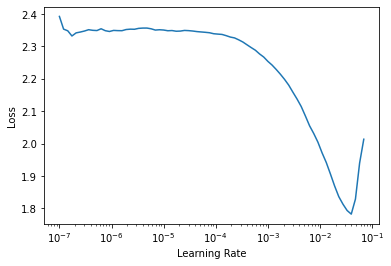

In [192]:
learn.lr_find()

In [193]:
learn.fit_one_cycle(1, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.059340,0.055695,0.983437,00:17


In [62]:
print(learn.summary())

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 8 x 14 x 14     80         True      
________________________________________________________________
Conv2d               64 x 8 x 14 x 14     584        True      
________________________________________________________________
Conv2d               64 x 8 x 14 x 14     584        True      
________________________________________________________________
Conv2d               64 x 16 x 7 x 7      1,168      True      
________________________________________________________________
Conv2d               64 x 16 x 7 x 7      2,320      True      
________________________________________________________________
Conv2d               64 x 16 x 7 x 7      2,320      True      
________________________________________________________________
Conv2d               64 x 32 x 4 x 4      4,640      True      
___________________________________________________

## fin

In [143]:
# fastaiのソースコード
class MergeLayer(Module):
    "Merge a shortcut with the result of the module by adding them or concatenating them if `dense=True`."
    def __init__(self, dense:bool=False): self.dense=dense
    def forward(self, x):
        if self.dense:
            return torch.cat([x,x.orig], dim=1) 
        else:
            return (x + x.orig)